In [2]:

import csv
import json
import os, sys
from glob import glob
from typing import Dict, List, Optional, Tuple, Union, Callable

sys.path.append('~/.local/lib/python3.7/site-packages')
import pybullet_envs
import dill
import wandb

import pdb

import gym
import numpy as np
import pandas
import warnings
import time
import argparse
import itertools
import random

from stable_baselines3.common.type_aliases import GymObs, GymStepReturn
from stable_baselines3.common.callbacks import BaseCallback, EventCallback
from stable_baselines3.common import logger
from stable_baselines3 import A2C, SAC, PPO, TD3
from stable_baselines3.common.vec_env import VecEnv, sync_envs_normalization, DummyVecEnv


In [2]:
# read in data from june 20 n=10 experiment

# steps:
# 1. read trial ids from trial_id_record.txt
# 2. go to corresponding folders, get data
# 3. observe correlation

In [3]:
data_dir = './experiments'

# starting folder: 1624108234

dir_contents = os.listdir(data_dir)
exp_folders = []

for item in dir_contents:
    if os.path.isdir('./experiments/'+item):
        if item >= '1624108234':
            exp_folders.append(item)

In [ ]:
# 10 evaluation episodes per checkpoint
# 1 main reward, 9 subtasks
# 100 checkpoints

# therefore, for each config, create a num_checkpoints x num_eval_episodes array x (1+num_subtasks)

In [35]:
def read_experiment_data(exp_id):

    config_record = np.empty([100, 10, 10])

    for i in range(100):
        with open('./experiments/'+str(exp_id)+'/'+str(i)+'_rewards', 'rb') as reward_file:
            reward_list = dill.load(reward_file)
        with open('./experiments/'+str(exp_id)+'/'+str(i)+'_infos', 'rb') as info_file:
            info_array = dill.load(info_file)
        checkpoint_record = np.concatenate((np.asarray([reward_list]).transpose(), info_array), axis=1)

        config_record[i,:,:] = checkpoint_record

    return config_record


In [ ]:
exp_record = np.empty([len(exp_folders), 100, 10, 10])

for j in range(len(exp_folders)):
    exp_record[j,:,:,:] = read_experiment_data(exp_folders[j])

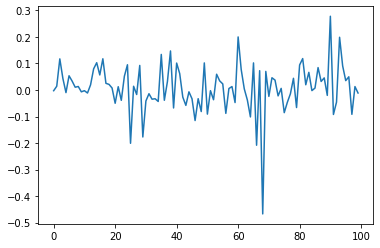

In [48]:
import matplotlib.pyplot as plt

plt.plot(np.mean(config_record[:,:,7], axis=1))

In [41]:
subtasks_names = [
    'right_knee_location', 'left_knee_location', # knees
    'right_knee_angular_velocity', 'left_knee_angular_velocity', 
    'right_hip_y_location', 'left_hip_y_location', # hips
    'right_hip_y_angular_velocity', 'left_hip_y_angular_velocity',
    'alive_bonus_easier' # half of original vertical position threshold 0.78
    ]

# create dictionary that maps subtask name to index 
subtasks_names_dict = dict(zip(subtasks_names, range(9)))